In [1]:
!pip install polars

In [2]:
import polars as pl
import pandas as pd
from datetime import datetime, timedelta

In [5]:
dataframe_pl = pl.DataFrame({
    'enter': [1, 2, 3],
    'date' : [
        (datetime(2024, 6, 20)),
        (datetime(2024, 7, 13)),
        (datetime(2022, 9, 12))
    ]
})

In [6]:
print(dataframe_pl)

shape: (3, 2)
┌───────┬─────────────────────┐
│ enter ┆ date                │
│ ---   ┆ ---                 │
│ i64   ┆ datetime[μs]        │
╞═══════╪═════════════════════╡
│ 1     ┆ 2024-06-20 00:00:00 │
│ 2     ┆ 2024-07-13 00:00:00 │
│ 3     ┆ 2022-09-12 00:00:00 │
└───────┴─────────────────────┘


In [8]:
df_pl_orders = pl.read_csv('../Sesion2/data/data_retail/orders', separator='|',has_header=False, new_columns=['order_id','order_date','order_customer_id','order_status'])

FileNotFoundError: No such file or directory (os error 2): ../Sesion2/data/data_retail/orders

In [ ]:
df_pl_orders.join(df_pl_order_items, left_on=)

In [ ]:
df_pl_orders.filter(pl.col('order_id')>1000)

In [ ]:
#lazy frames 


In [8]:
import numpy as np 


In [9]:
filas = 2000
rng = np.random.default_rng(seed=7) #semillas hace el random una vez y despues devolvera los mismos valores 
data = {
    'precio': rng.exponential(scale=1000, size=filas),
    'anio': rng.integers(low=1995, high=2024, size=filas),
    'tipo': rng.choice(['A','B','C'], size=filas)
}

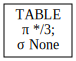

In [11]:
df_pl_lazy = pl.LazyFrame(data)
df_pl_lazy.show_graph()

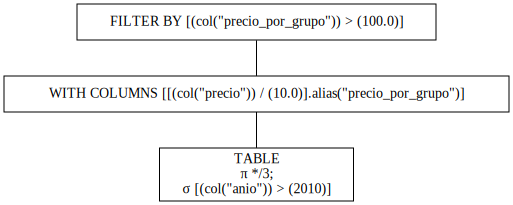

In [13]:
lazy_query = (
    df_pl_lazy
    .with_columns(
        (pl.col('precio')/10).alias('precio_por_grupo')
    )
    .filter(pl.col("precio_por_grupo")>100)
    .filter(pl.col("anio")>2010)
)
lazy_query.show_graph()

In [15]:
print(lazy_query.explain())

FILTER [(col("precio_por_grupo")) > (100.0)] FROM
   WITH_COLUMNS:
   [[(col("precio")) / (10.0)].alias("precio_por_grupo")], [] 
    DF ["precio", "anio", "tipo"]; PROJECT */3 COLUMNS; SELECTION: [(col("anio")) > (2010)]


In [16]:
lazy_query.collect()

precio,anio,tipo,precio_por_grupo
f64,i64,str,f64
1073.700662,2016,"""A""",107.370066
1884.250052,2014,"""B""",188.425005
3144.673318,2019,"""C""",314.467332
1014.258665,2023,"""B""",101.425867
1404.422293,2013,"""C""",140.442229
…,…,…,…
2134.210945,2012,"""A""",213.421094
1401.054607,2011,"""C""",140.105461
2062.191584,2019,"""A""",206.219158


In [19]:
import requests
import pathlib

def descarga(url: str,file_path: pathlib.Path):
    response = requests.get(url)

    if response:
        file_path.write_bytes(response.content)
    else: 
        print("Ocurrio un error")



In [20]:
url = "https://data.wa.gov/api/views/f6w7-q2d2/rows.csv?accessType=DOWNLOAD"
file_path = pathlib.Path("cars.csv")

descarga(url, file_path)

In [21]:
#scan para leer el archivo. 
lazy_car = pl.scan_csv(file_path)
lazy_car

In [24]:
lazy_car.select(pl.col('State')).collect()

State
str
"""WA"""
"""WA"""
"""WA"""
"""WA"""
"""WA"""
…
"""WA"""
"""WA"""
"""WA"""


In [25]:
lazy_query = (
    lazy_car
    .filter(pl.col('Model Year') >= 2018)
    .filter(pl.col('Electric Vehicle Type') == "Battery Electric Vehicle(BI)")
    .group_by(['State', 'Make'])
    .agg(
        pl.mean("Electric Range").alias("Electric Range"),
        pl.len().alias("numero de carros")
    )
    .filter(pl.col("numero de carros")> 5)
)
lazy_query

In [26]:
lazy_query.explain()

'FILTER [(col("numero de carros")) > (5)] FROM\n  AGGREGATE\n  \t[col("Electric Range").mean().alias("Electric Range"), len().alias("numero de carros")] BY [col("State"), col("Make")] FROM\n\n      Csv SCAN cars.csv\n      PROJECT 5/17 COLUMNS\n      SELECTION: [([(col("Electric Vehicle Type")) == (String(Battery Electric Vehicle(BI)))]) & ([(col("Model Year")) >= (2018)])]'

In [27]:
lazy_query.collect()

State,Make,Electric Range,numero de carros
str,str,f64,u32
